In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Plot for regression

In [2]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012
5,5,RBS_1by1_5,bps_noncore,TGTAAGAAGGAGATATACAT,AGGAGA,0.288674,0.268222,0.486638,0.254308,0.342162,0.501763,0.328001,0.094759
6,6,RBS_1by1_6,bps_noncore,TATAAGAAGGAGATATACAT,AGGAGA,1.003687,1.116599,0.851400,0.866754,1.075506,1.462978,0.982789,0.120068
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,1.138820,1.342549,NaN,1.626269,1.423415,1.806580,1.382763,0.201720
8,9,RBS_1by1_9,bps_noncore,TTAAAGAAGGAGATATACAT,AGGAGA,0.508605,0.646307,1.153507,0.488646,0.406578,0.583543,0.640728,0.299326
9,10,RBS_1by1_10,bps_noncore,TTTCAGAAGGAGATATACAT,AGGAGA,1.119059,0.876151,0.624684,1.321343,1.066000,1.621663,1.001447,0.263620


Refer to [Gaussian process regression (GPR) with noise-level estimation](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html)  
with alpha only: predict different values for the same sequence  
with WhiteKernel: predict same values for the same sequence

X train shape:  (845, 20)
X test shape:  (210, 20)
create kernel instance
[-4.30172369e-12 -3.80769513e-14 -1.14153758e-14 ...  5.44020074e+01
  6.14119275e+01  1.98434846e+02]
finish creating kernel instance
[-4.30172369e-12 -3.80769513e-14 -1.14153758e-14 ...  5.44020074e+01
  6.14119275e+01  1.98434846e+02]
[-4.30172369e-12 -3.80769513e-14 -1.14153758e-14 ...  5.44020074e+01
  6.14119275e+01  1.98434846e+02]
<function mean_squared_error at 0x7f4dceafeb70>
Train:  0.689398233855824
Test:  0.48302672353507037
<function r2_score at 0x7f4dceafed90>
Train:  0.3457503153053463
Test:  0.32629321752790497


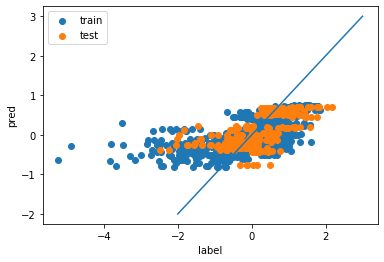

In [27]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 0, alpha = 25, eva_on='samples')
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()

In [4]:
gpr_train_samples.gp_reg.kernel_

WD_Shift_Kernel() + WhiteKernel(noise_level=1e-05)

In [5]:
gpr_train_samples.train_df

,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
0,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep1,1.166174,0.763838,0.623871
1,ATTAAGAAGGAGATATACAT,AGGAGA,1.338765,0.097386,bps_noncore,Rep1,1.221264,0.755878,0.623871
2,TCTAAGAAGGAGATATACAT,AGGAGA,1.382669,0.210012,bps_noncore,Rep1,1.160566,0.779547,0.668123
3,TATAAGAAGGAGATATACAT,AGGAGA,0.982789,0.120068,bps_noncore,Rep1,1.003687,0.752380,0.668123
4,TTGAAGAAGGAGATATACAT,AGGAGA,1.382763,0.201720,bps_noncore,Rep1,1.138820,0.773084,0.696239
...,...,...,...,...,...,...,...,...,...
841,TTTAAGATAAGGGTATACAT,TAAGGG,0.564876,0.143604,prob random,Rep6,0.432208,-0.095852,0.712131
842,TTTAAGATAGTCTTATACAT,TAGTCT,0.585487,0.184425,prob random,Rep6,0.260032,-0.129764,0.775354
843,TTTAAGAAAGTAGTATACAT,AAGTAG,0.380490,0.159538,prob random,Rep6,-0.182145,-0.048756,0.785325
844,TTTAAGAGTAATGTATACAT,GTAATG,0.244736,0.169817,prob random,Rep6,-0.036484,-0.261140,0.772087


In [6]:
gpr_train_samples.train_df[gpr_train_samples.train_df['RBS'] == 'CTTAAGAAGGAGATATACAT']

,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
0,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep1,1.166174,0.763838,0.623871
141,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep2,1.337018,0.763838,0.623871
282,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep3,1.417248,0.763838,0.623871
423,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep4,1.493800,0.763838,0.623871
564,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep5,1.713526,0.763838,0.623871
705,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep6,1.644568,0.763838,0.623871


In [7]:
gpr_train_samples.test_df[gpr_train_samples.test_df['RBS'] == 'TTTAAGATAAGATTATACAT']

,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
0,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep1,-0.440723,-0.078991,0.770954
35,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep2,-1.407786,-0.078991,0.770954
70,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep3,-1.373892,-0.078991,0.770954
105,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep4,-2.035393,-0.078991,0.770954
140,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep5,-0.553289,-0.078991,0.770954
175,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep6,-0.662509,-0.078991,0.770954


In [8]:
wd_kernel =  WD_Shift_Kernel(l = 6, features = gpr_train_samples.features, s = 1)
#kernel_matrix_samples = wd_kernel.cal_kernel(np.asarray(gpr_train_samples.train_df['RBS']), np.asarray(gpr_train_samples.train_df['RBS']))
#np.linalg.eig(kernel_matrix)
kernel_matrix_samples = wd_kernel.kernel_all_normalised

[-1.12818386e-13 -8.82888353e-14 -1.52872116e-14 ...  5.34927244e+01
  6.83210989e+01  1.90198593e+02]


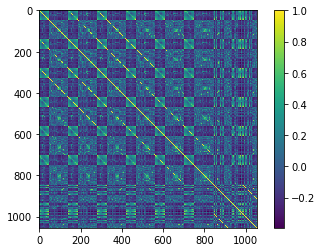

In [9]:
plt.imshow(kernel_matrix_samples)
plt.colorbar()

In [10]:
kernel_matrix_samples[0].all() == kernel_matrix_samples[141].all()

True

In [11]:
np.linalg.eigh(kernel_matrix_samples)

(array([-1.12818386e-13, -8.82888353e-14, -1.52872116e-14, ...,
         5.34927244e+01,  6.83210989e+01,  1.90198593e+02]),
 array([[ 1.29208795e-18,  1.88444258e-01,  0.00000000e+00, ...,
          2.56618638e-03, -4.59912373e-03, -5.75086065e-02],
        [ 1.46881185e-01,  2.08851521e-01,  2.53453915e-02, ...,
          2.56620396e-03, -4.59913819e-03, -5.75086351e-02],
        [ 5.03744553e-02,  1.64048078e-02, -1.52336417e-01, ...,
          2.33511667e-03, -4.41888309e-03, -5.23375806e-02],
        ...,
        [ 3.19352227e-02, -1.21137175e-02,  7.64527648e-03, ...,
          1.35727471e-02,  2.71121776e-02,  2.09740522e-02],
        [ 3.78411985e-03, -4.21718686e-02,  1.18263455e-03, ...,
          1.35821950e-02, -5.24811683e-03, -4.84081878e-02],
        [ 1.87649816e-02, -1.87117145e-02,  7.46340648e-03, ...,
          2.56620082e-03, -4.59913538e-03, -5.75086296e-02]]))

In [12]:
one_vec = np.ones((kernel_matrix_samples.shape[0],1))
one_mat = np.ones(kernel_matrix_samples.shape)
row_sum = np.mean(kernel_matrix_samples,axis=0).T
K = kernel_matrix_samples - (row_sum * one_vec.T + one_vec * row_sum.T -np.mean(row_sum)*one_mat)

In [13]:
kernel_matrix_samples

array([[ 1.        ,  0.80928211,  0.70447756, ..., -0.2413588 ,
         0.47677101,  0.80928211],
       [ 0.80928211,  1.        ,  0.68239636, ..., -0.2413588 ,
         0.47677101,  0.80928211],
       [ 0.70447756,  0.68239636,  1.        , ..., -0.21925124,
         0.41577697,  0.68239636],
       ...,
       [-0.2413588 , -0.2413588 , -0.21925124, ...,  1.        ,
        -0.19794531, -0.2413588 ],
       [ 0.47677101,  0.47677101,  0.41577697, ..., -0.19794531,
         1.        ,  0.47677101],
       [ 0.80928211,  0.80928211,  0.68239636, ..., -0.2413588 ,
         0.47677101,  1.        ]])

In [14]:
kernel_matrix_samples.shape

(1055, 1055)

X train shape:  (845, 20)
X test shape:  (210, 20)
create kernel instance
[-4.30172369e-12 -3.80769513e-14 -1.14153758e-14 ...  5.44020074e+01
  6.14119275e+01  1.98434846e+02]
finish creating kernel instance
[-4.30172369e-12 -3.80769513e-14 -1.14153758e-14 ...  5.44020074e+01
  6.14119275e+01  1.98434846e+02]
[-4.30172369e-12 -3.80769513e-14 -1.14153758e-14 ...  5.44020074e+01
  6.14119275e+01  1.98434846e+02]
<function mean_squared_error at 0x7f4dceafeb70>
Train:  0.03965333667455428
Test:  0.5312568028314454
<function r2_score at 0x7f4dceafed90>
Train:  0.9522994049042185
Test:  0.06301954881574723


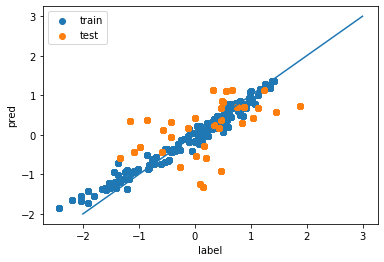

In [15]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_seqs = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 0, alpha = 0.5, eva_on='seqs')
gpr_train_seqs.regression()
gpr_train_seqs.scatter_plot()

In [16]:
gpr_train_seqs.test_df

,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
0,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep1,-0.440723,0.353420,0.475469
1,TTTAAGATACTGATATACAT,TACTGA,0.439430,0.175760,prob random,Rep1,0.381380,0.177895,0.682306
2,TTTAAGAGCCGGATATACAT,GCCGGA,0.467489,0.165976,bandit,Rep1,0.575108,0.366982,0.525469
3,TTTAAGACCGGGATATACAT,CCGGGA,-0.849142,0.667608,prob random,Rep1,-0.911192,0.380437,0.708134
4,TTTAAGAAGGAGATATACAC,AGGAGA,0.886371,0.164598,bps_noncore,Rep1,0.855386,0.694993,0.507983
...,...,...,...,...,...,...,...,...,...
205,TTTAAGAAGGGGATATACAT,AGGGGA,-0.417084,0.603439,bps_core,Rep6,0.030040,0.323931,0.642043
206,TTTAAGAAGGGGTTATACAT,AGGGGT,0.839342,0.266306,prob random,Rep6,0.974875,0.290776,0.577834
207,TTTAAGACCGGATTATACAT,CCGGAT,0.486672,0.163484,bandit,Rep6,0.004681,0.860292,0.633633
208,TTTAAGAAGGAGATATGCAT,AGGAGA,0.474474,0.361571,bps_noncore,Rep6,0.511145,0.678189,0.647020


## Repeated KFold

In [17]:
import pickle

with open('kflod_results/repeated_kfold_wd_shift_logTrue_evaSeq.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [18]:
import xarray
result_test_s0_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 0)].mean(axis = -1).mean(axis = -1)
result_test_s1_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 1)].mean(axis = -1).mean(axis = -1)
result_test_s2_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 2)].mean(axis = -1).mean(axis = -1)

In [19]:
result_test_s0_aveSplit_aveRepeat

<xarray.DataArray (alpha: 21, l: 4)>
array([[1.26233808, 1.21934278, 1.22246368, 1.10961882],
       [0.87459999, 0.87055171, 0.89713976, 0.85547907],
       [0.80702986, 0.83542606, 0.7892894 , 0.79315209],
       [0.79325253, 0.78738795, 0.77396435, 0.75315738],
       [0.7807854 , 0.79277263, 0.74850416, 0.74925239],
       [0.78557403, 0.76527113, 0.75953693, 0.74250648],
       [0.77974293, 0.7499474 , 0.75541773, 0.73589765],
       [0.76827697, 0.76355223, 0.75677268, 0.76297781],
       [0.77190605, 0.755155  , 0.74417191, 0.73820289],
       [0.76817021, 0.7678082 , 0.74778035, 0.7373879 ],
       [0.76324691, 0.76190945, 0.74107088, 0.73617823],
       [0.77021022, 0.75805215, 0.75020015, 0.75312134],
       [0.77042698, 0.76062137, 0.75078407, 0.74486233],
       [0.78048303, 0.75572055, 0.74794436, 0.74768476],
       [0.7685245 , 0.75632756, 0.74770342, 0.74510788],
       [0.76589546, 0.76415929, 0.74522604, 0.74827753],
       [0.77253683, 0.76538293, 0.74385624, 0.74639469],
       [0.77443947, 0.76357087, 0.7573345 , 0.74543478],
       [0.76844234, 0.7607419 , 0.74840374, 0.74997674],
       [0.77345261, 0.76044826, 0.75561943, 0.75037812],
       [0.76387207, 0.76333613, 0.75403397, 0.75108625]])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
  * l           (l) <U3 '[3]' '[4]' '[5]' '[6]'
    s           int64 0

In [20]:
result_test_s0_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]
result_test_s1_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]
result_test_s2_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]

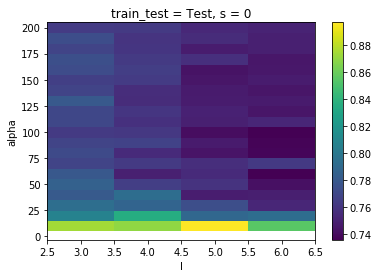

In [21]:
result_test_s0_aveSplit_aveRepeat.where(result_test_s0_aveSplit_aveRepeat < 1).plot()

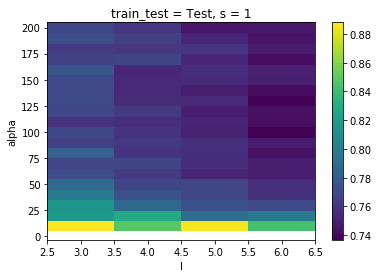

In [22]:
result_test_s1_aveSplit_aveRepeat.where(result_test_s1_aveSplit_aveRepeat < 1).plot()

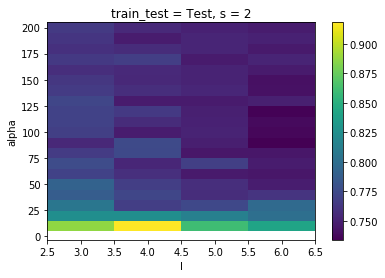

In [23]:
result_test_s2_aveSplit_aveRepeat.where(result_test_s2_aveSplit_aveRepeat < 1).plot()

In [24]:
# average mean square error for testing 

result_pkl[1].loc[dict(s = 1)].loc[dict(l = '[6]')].mean(axis = -1).mean(axis = -1)

<xarray.DataArray (alpha: 21)>
array([1.1512797 , 0.84359855, 0.79909973, 0.77068351, 0.75755586,
       0.75657694, 0.74872428, 0.74963607, 0.74386427, 0.74837986,
       0.73680298, 0.74181425, 0.74306736, 0.73768472, 0.74125225,
       0.75029304, 0.75087085, 0.74175137, 0.74907985, 0.74476065,
       0.74683378])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
    l           <U3 '[6]'
    s           int64 1

In [25]:
# std of mean square error for testing

result_pkl[1].loc[dict(s = 1)].loc[dict(l = '[6]')].mean(axis = -1).std(axis = -1)

<xarray.DataArray (alpha: 21)>
array([0.09969509, 0.02697518, 0.04492847, 0.02948356, 0.02706565,
       0.0233904 , 0.02620881, 0.02209315, 0.02025293, 0.01341702,
       0.01194087, 0.02283254, 0.01004528, 0.01353901, 0.01234023,
       0.01097683, 0.01417145, 0.01417162, 0.02050755, 0.00907089,
       0.00887418])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
    l           <U3 '[6]'
    s           int64 1